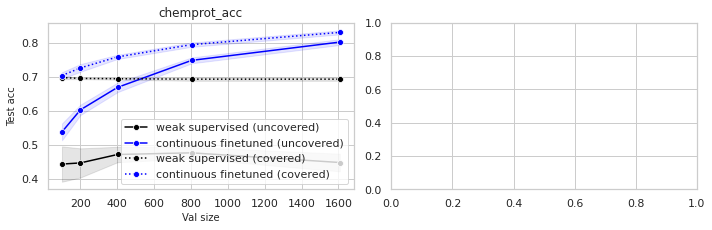

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import json
import numpy as np

N_RUNS = 5 

# Dataset metadata
dataset_metadata = {
    'amazon31': {'n_class': 31, "train_size": 131781, "val_size": 5805, 'metric': 'acc'},
    'banking77': {'n_class': 77, "train_size": 9003, "val_size": 1000, 'metric': 'acc'},
    'chemprot_f1': {'n_class': 10, "train_size": 12600, "val_size": 1607, 'metric': 'f1_macro', 'coverage': 0.86},
    'chemprot_acc': {'n_class': 10, "train_size": 12861, "val_size": 1607, 'metric': 'acc', 'coverage': 0.86},
    # Add other datasets if needed
}

datapath = "./results_forgraph"
# Define the paths to your result files
files_per_data = [

    (f"{datapath}/chemprot_acc/uncovered-fine.json", 'fine_tune_on_val', 'solid'),
    (f"{datapath}/chemprot_acc/covered-fine.json", 'fine_tune_on_val', 'dotted'),
    # Add other datasets if needed
]

# Plot settings
sns.set(style="whitegrid")
pip_to_color = {'supervised': 'red', 'weak supervised': 'black', 'continuous finetuned': 'blue'}
fig, axs = plt.subplots(1, 2, figsize=(10,3.3))

# To store data for combined plotting
plot_data = {}

# Process each dataset and store plot data
for filepath, pip, linestyle in files_per_data:
    with open(filepath) as f:
        dataset_name = filepath.split("/")[2]

        result_dict = json.load(f)
        x = result_dict.keys()
        if len(x) <= 1:
            continue
        if pip in ['fine_tune_on_val', 'supervised']:
            if dataset_metadata[dataset_name]['metric'] not in result_dict[list(x)[0]]["em_test"].keys():
                continue
            x = np.array(list(x)).astype(float) * dataset_metadata[dataset_name]['val_size']
            em_test = [result_dict[k]["em_test"] for k in result_dict]
            em_test_mean, em_test_std = zip(*[list(v.values())[0] for v in em_test])
            em_test_se = np.array(em_test_std) / np.sqrt(N_RUNS)
            
            # Store plot data
            if dataset_name not in plot_data:
                plot_data[dataset_name] = {'x': x, 'data': []}
            plot_data[dataset_name]['data'].append((pip, em_test_mean, em_test_se, result_dict, linestyle))

# Plot combined data
counter_x = 0
for dataset_name, values in plot_data.items():
    ax = axs[counter_x]
    for pip, em_test_mean, em_test_se, result_dict, linestyle in values['data']:
        pip_label = pip
        if pip == 'fine_tune_on_val':
            pip_label = 'weak supervised'
        sns.lineplot(x=values['x'], y=em_test_mean, ax=ax, label=f"{pip_label} ({'covered' if linestyle == 'dotted' else 'uncovered'})" if pip != 'supervised' else pip_label, 
                     color=pip_to_color[pip_label], linestyle=linestyle, marker='o')
        ax.fill_between(values['x'], np.array(em_test_mean) - 1.96 * em_test_se, np.array(em_test_mean) + 1.96 * em_test_se, 
                        alpha=0.1, color=pip_to_color[pip_label])

        if pip == 'fine_tune_on_val':
            l = 'continuous finetuned'
            tuned_em_test = [result_dict[k]["tuned_em_test"] for k in result_dict]
            tuned_em_test_mean, tuned_em_test_std = zip(*[list(v.values())[0] for v in tuned_em_test])
            tuned_em_test_se = np.array(tuned_em_test_std) / np.sqrt(N_RUNS)
            sns.lineplot(x=values['x'], y=tuned_em_test_mean, ax=ax, label=f"{l} ({'covered' if linestyle == 'dotted' else 'uncovered'})", 
                         color=pip_to_color[l], linestyle=linestyle, marker='o')
            ax.fill_between(values['x'], np.array(tuned_em_test_mean) - 1.96 * tuned_em_test_se, 
                            np.array(tuned_em_test_mean) + 1.96 * tuned_em_test_se, alpha=0.1, color=pip_to_color[l])

    ax.set_title(f"{dataset_name}", fontsize=12)
    ax.set_xlabel("Val size", fontsize=10)
    ax.set_ylabel(f"Test {dataset_metadata[dataset_name]['metric']}", fontsize=10)
    
    ax.legend(loc='lower right')  # Move legend inside the plot area for each plot

    counter_x += 1
    if counter_x == 2:
        break

# Adjust layout and show plot
plt.tight_layout()
plt.savefig('chemprot_acc.pdf')
plt.show()